In [1]:
import time
import numpy as np
import gym
from gym import spaces
from collections import defaultdict
import math
import itertools
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import plotly.graph_objects as go
import pandas as pd
import time

# Environment

In [2]:
class SmartCharging(gym.Env):
    def __init__(self, actions, cap, stuck_penalty):
        super(SmartCharging, self).__init__()
        
        self.actions = actions  
        self.cap = cap
        self.stuck_penalty = stuck_penalty
        
        self.episode = 0 #Current training episode. This is used in the random start training after n episodes.
        self.old_level = 0 #Battery level at the end of the last episode.
        self.stuck = False
        self.action_space = spaces.Discrete(len(self.actions))
        self.observation_space = spaces.Dict({
            'level': spaces.Discrete(self.cap+1),
            'time': spaces.Discrete(8)
        })
        
        self.state = {
            'level': 0,
            'time': 0
        }      
        
        self.done = False
        
    def reset(self):
        self.state = {
            'level': self.old_level,
            'time': 0
        }
        self.done = False
        return self.state
    
    def reset_random(self):
        self.state = {
            'level': np.random.randint(0,100),
            'time': np.random.randint(0,7)
        }
        self.done = False
        return self.state

    def reset_episode(self): #Call this after every training!
        self.episode=0

    def step(self, action):
        loaded = self.actions.get(action) #Determines how much kWh are loaded.
        reward = 0

        if loaded + self.state['level'] > self.cap: #Loading would exceed battery capacity.
            reward -= cost_func(self.state['time'], self.cap - self.state['level']) #Only receive cost for actually loaded kWh below capcity.
            self.state['level'] = self.cap
        else:
            reward -= cost_func(self.state['time'], loaded)
            self.state['level'] += loaded

        self.state['time'] += 1

        if self.state['time'] == 8: #Terminal state. 
            consumed = power_consumed()
            if self.state['level'] - consumed >= 0: #Car had enough energy for the day.
                self.old_level = self.state['level'] - consumed
                self.stuck = False
            else: #Car gets stuck.
                self.old_level = 0
                self.stuck = True
                reward += self.stuck_penalty
                
            self.reset()
                
            self.episode += 1
            self.done = True
            
        return self.state, reward, self.done, self.stuck
    
def cost_func(t, p):
    '''
    This method returns the costs for charging
    @param t:  time
    @param p:  charging rate
    '''
    # alpha_time is the coefficient for time
    alpha_time = [0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
    #alpha_time = [1,1,1,1,1,1,1,1] 
    return alpha_time[t] * math.exp(p/2)

def power_consumed(mu=30, sigma=5):
    '''
    This method returns power consumed by the taxi driver
    @param mu: mean
    @param sigma: standard deviation
    '''
    return int(np.random.normal(mu, sigma, 1)[0])

# Agents

## Monte Carlo 

In [3]:
class MC_Agent():
    def __init__(self, alpha, gamma, env, epsilon, epsilon_decay, epsilon_min,alpha_decay): 
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.alpha_decay = alpha_decay
        
        self.action_space_size = self.env.action_space.n 
        self.q_table = defaultdict(lambda: np.zeros(self.action_space_size))
        self.q_table_count = defaultdict(lambda: np.zeros(self.action_space_size))

    def pick_action(self, state):
        action_q_values = self.q_table.get((state['time'], state['level']), np.zeros(self.action_space_size))
        # Initialize Q-values for new state (not in table yet) with all actions to 0.  
        return self.epsilon_greedy(action_q_values)

    def epsilon_greedy(self, action_q_values):
        if np.random.rand() < self.epsilon or np.all(action_q_values==0): #Probability ε or state was never visited before.
            # Exploration: Choose a random action
            chosen_action = np.random.choice(range(self.action_space_size))
        else:
            # Exploitation: Choose the action with the highest Q-value.
            chosen_action = np.argmax(action_q_values)

        if self.epsilon > self.epsilon_min: 
            self.epsilon *= self.epsilon_decay

        return chosen_action

    def update_q_values(self, state, action, goal): #Update via Monte Carlo update rules.
        state_key = (state['time'], state['level'])
        
        if self.alpha_decay:
            self.q_table_count[state_key][action] += 1
            learning_rate = self.alpha / self.q_table_count[state_key][action] #Alpha decay. Each visit at the same State reduces the learn rate.
            self.q_table[state_key][action] += learning_rate * (goal - self.q_table[state_key][action])
        else:
            self.q_table[state_key][action] += self.alpha * (goal - self.q_table[state_key][action])
        
    def train(self, iterations,random_iter):
        for i in range(iterations):
            if i < random_iter: #Train with random initial state.
                current_state = self.env.reset_random()
            else:
                current_state = self.env.reset()
                
            episode = []
            done = False
            
            while not done: #Go through one episode until terminal state is reached.         
                action = self.pick_action(current_state)
                old_state = current_state.copy()
                current_state, reward, done, _ = self.env.step(action)
                episode.append((old_state, action, reward))

            goal = 0
            for state, action, reward in reversed(episode): #Traverse episode backwards and apply Monte Carlo rules.
                goal = reward + self.gamma * goal
                self.update_q_values(state, action, goal)
                
        self.env.reset_episode()
        return self.q_table

## SARSA

In [4]:
class SARSA_Agent():
    def __init__(self, alpha, gamma, env, epsilon, epsilon_decay, epsilon_min,alpha_decay):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.alpha_decay = alpha_decay
        
        self.action_space_size = env.action_space.n
        self.q_table = defaultdict(lambda: np.zeros(self.action_space_size))
        self.q_table_count = defaultdict(lambda: np.zeros(self.action_space_size))

    def pick_action(self, state):
        action_q_values = self.q_table.get((state['time'], state['level']), np.zeros(self.action_space_size))
        # Initialize Q-values for new state (not in table yet) with all actions to 0.  
        return self.epsilon_greedy(action_q_values)

    def epsilon_greedy(self, action_q_values):
        if np.random.rand() < self.epsilon or np.all(action_q_values==0): #Probability ε or state was never visited before.
            # Exploration: Choose a random action
            chosen_action = np.random.choice(range(self.action_space_size))
        else:
            # Exploitation: Choose the action with the highest Q-value.
            chosen_action = np.argmax(action_q_values)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return chosen_action

    def update_q_values(self, state, action, reward, next_state, next_action, done): #Update via SARSA update rules.
        state_key = (state['time'], state['level'])
        next_state_key = (next_state['time'], next_state['level'])

        td_target = reward + self.gamma * self.q_table[next_state_key][next_action] * (1 - done) #Set everything to 0 if done.
        td_error = td_target - self.q_table[state_key][action]
        
        if self.alpha_decay:
            self.q_table_count[state_key][action] += 1
            learning_rate = self.alpha / self.q_table_count[state_key][action] #Alpha decay. Each visit at the same State reduces the learn rate.
            self.q_table[state_key][action] += learning_rate * td_error
        else:
            self.q_table[state_key][action] += self.alpha * td_error
                
    def train(self, iterations,random_iter):
        for i in range(iterations):
            if i < random_iter: #Train with random initial state.
                state = self.env.reset_random()
            else:
                state = self.env.reset()
            action = self.pick_action(state)
            done = False

            while not done: #Go through one episode until terminal state is reached. 
                next_state, reward, done, _ = self.env.step(action)
                next_action = self.pick_action(next_state)

                self.update_q_values(state, action, reward, next_state, next_action, done)

                state = next_state.copy()
                action = next_action
        
        self.env.reset_episode()
        return self.q_table

## Q Learning

In [50]:
class QLearning_Agent():
    def __init__(self, alpha, gamma, env, epsilon, epsilon_decay, epsilon_min,alpha_decay):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.alpha_decay = alpha_decay
        
        self.action_space_size = env.action_space.n 
        self.q_table = defaultdict(lambda: np.zeros(self.action_space_size))
        self.q_table_count = defaultdict(lambda: np.zeros(self.action_space_size))

    def pick_action(self, state):
        action_q_values = self.q_table.get((state['time'], state['level']), np.zeros(self.action_space_size))
        # Initialize Q-values for new state (not in table yet) with all actions to 0.  
        return self.epsilon_greedy(action_q_values)

    def epsilon_greedy(self, action_q_values):
        if np.random.rand() < self.epsilon or np.all(action_q_values==0): #Probability ε or state was never visited before.
            # Exploration: Choose a random action
            chosen_action = np.random.choice(range(self.action_space_size))
        else:
            # Exploitation: Choose the action with the highest Q-value.
            chosen_action = np.argmax(action_q_values)

        if self.epsilon > self.epsilon_min: 
            self.epsilon *= self.epsilon_decay

        return chosen_action

    def update_q_values(self, state, action, reward, next_state, done): #Update via Q-learning update rules.
        state_key = (state['time'], state['level'])
        next_state_key = (next_state['time'], next_state['level'])
        
        best_next_action = np.argmax(self.q_table[next_state_key])
        td_target = reward + self.gamma * self.q_table[next_state_key][best_next_action] * (1 - done) #Set everything to 0 if done.
        td_error = td_target - self.q_table[state_key][action]
        
        if self.alpha_decay:
            self.q_table_count[state_key][action] += 1
            learning_rate = self.alpha / self.q_table_count[state_key][action] #Alpha decay. Each visit at the same State reduces the learn rate.
            self.q_table[state_key][action] += learning_rate * td_error
        else:
            self.q_table[state_key][action] += self.alpha * td_error
    def train(self, iterations,random_iter):
        for i in range(iterations):
            if i < random_iter: #Train with random initial state.
                state = self.env.reset_random()
            else:
                state = self.env.reset()
            done = False

            while not done: #Go through one episode until terminal state is reached. 
                action = self.pick_action(state)
                next_state, reward, done, _ = self.env.step(action)
                self.update_q_values(state, action, reward, next_state, done)
                state = next_state.copy()

            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
            
        self.env.reset_episode()    
        return self.q_table

## Deep Q-Network

In [6]:
class DQN_Agent():
    def __init__(self, env, alpha, gamma, epsilon, epsilon_decay, epsilon_min, alpha_decay, alpha_min, memory_size, batch_size, target_update=10):
        self.env = env
        self.state_size = 2  # time and level
        self.action_size = env.action_space.n 
        self.alpha = alpha  # Initial learning rate
        self.gamma = gamma  
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay 
        self.epsilon_min = epsilon_min
        self.alpha_decay = alpha_decay  # Decay rate for learning rate
        self.alpha_min = alpha_min      # Minimum learning rate
        self.batch_size = batch_size  
        self.target_update = target_update  

        # Experience replay memory
        self.memory = deque(maxlen=memory_size)

        # Main network
        self.model = self.build_model()

        # Target Q-network
        self.target_model = self.build_model()
        self.update_target_model()
        
        # Stochastic optimizer
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.alpha)

    def build_model(self):
        model = nn.Sequential(
            nn.Linear(self.state_size, 64),  # Input layer
            nn.ReLU(), 
            nn.Linear(64, 64),  # Hidden layer
            nn.ReLU(), 
            nn.Linear(64, self.action_size)  # Output layer (number of actions)
        )
        return model

    def update_target_model(self):
        # Copy weights from main Q-network to target network.
        self.target_model.load_state_dict(self.model.state_dict())

    def pick_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Exploration: random action
        state = torch.FloatTensor(state).unsqueeze(0)  # Convert state to tensor and add batch dimension
        with torch.no_grad():
            q_values = self.model(state)
        return torch.argmax(q_values).item()  # Exploitation: choose action with highest Q-value

    def store_experience(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        # Perform experience replay if enough samples are available.
        if len(self.memory) < self.batch_size:
            return 

        minibatch = random.sample(self.memory, self.batch_size)

        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            
            target = reward
            if not done:
                target += self.gamma * torch.max(self.target_model(next_state)).item() # Calculate target as reward + discounted max future Q-value.
            
            target_f = self.model(state).clone().detach() # Current Q-value for selected action.
            target_f[action] = target

            loss = nn.MSELoss()(self.model(state), target_f)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        # Update epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        self.alpha = max(self.alpha_min, self.alpha * self.alpha_decay)
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.alpha

    def generate_state_space_keys(self):
        state_space_keys = []
        for time in range(self.env.observation_space['time'].n):
            for level in range(self.env.observation_space['level'].n):
                state_space_keys.append((time, level))
        return state_space_keys

    def extract_q_table(self):
        q_table = {}
        state_space_keys = self.generate_state_space_keys()

        for state_key in state_space_keys:
            state = torch.FloatTensor(state_key).unsqueeze(0)
            with torch.no_grad():
                q_values = self.model(state).numpy().flatten()
            q_table[state_key] = q_values

        return q_table

    def train(self, episodes, random_iter):
        for e in range(episodes):
            if e < random_iter:  # Train with random initial state for exploration
                state = self.env.reset_random()
            else:
                state = self.env.reset()
            state = np.array([state['time'], state['level']])

            done = False
            total_reward = 0

            while not done:  # Go through one episode until terminal state is reached
                action = self.pick_action(state)
                next_state, reward, done, _ = self.env.step(action)
                next_state = np.array([next_state['time'], next_state['level']])
                total_reward += reward

                self.store_experience(state, action, reward, next_state, done)
                state = next_state
                self.replay()

            # Update target model periodically.
            if e % self.target_update == 0:
                self.update_target_model()


        self.env.reset_episode()
        return self.extract_q_table()

# Evaluation methods

In [140]:
def plot_q_table_3d(q_table, cap):
    """
    Plots a 3D surface of the Q-table showing the relationship between 
    battery level, time, and Q-values.

    Parameters:
    - q_table (dict): The Q-table where keys are state tuples and values are lists/arrays of Q-values for different actions.
    - cap (int): The maximum battery level.
    """

    def get_Z(key):
        return np.average(q_table[key])

    # battery level
    X = np.arange(cap + 1)
    # time
    Y = np.arange(8)
    X_grid, Y_grid = np.meshgrid(X, Y)
    # average Q-values (policy)
    Z = np.array([get_Z(key) for key in itertools.product(Y, X)]).reshape((8, cap + 1))

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(X_grid, Y_grid, -Z, cmap='viridis')

    ax.view_init(elev=30, azim=45)

    ax.set_zlabel('Average Q-value')
    ax.set_ylabel('Time')
    ax.set_xlabel('Battery level')
    plt.tight_layout()
    plt.show()

def plot_q_table_2d(q_table):
    """
    Plots a 2D heatmap of the average Q-values over all actions for each state in the Q-table.

    Parameters:
    - q_table (dict): The Q-table where keys are state tuples and values are lists/arrays of Q-values for different actions.
    """

    levels = sorted(set(state[1] for state in q_table.keys()))
    times = sorted(set(state[0] for state in q_table.keys()))

    # Initialize a matrix with zeros
    q_matrix = np.zeros((len(levels), len(times)))

    # Fill the matrix with average Q-values
    for state_key, q_values in q_table.items():
        time, level = state_key
        if level in levels and time in times:
            level_idx = levels.index(level)
            time_idx = times.index(time)
            q_matrix[level_idx, time_idx] = np.mean(q_values)

    fig, ax = plt.subplots(figsize=(len(times), len(levels)))
    cax = ax.matshow(q_matrix, cmap='viridis')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(times)))
    ax.set_xticklabels(times)
    ax.set_yticks(np.arange(len(levels)))
    ax.set_yticklabels(levels)

    # Annotate the matrix with Q-values
    for i in range(len(levels)):
        for j in range(len(times)):
            value = q_matrix[i, j]
            ax.text(j, i, f"{value:.2f}", ha='center', va='center', color='white')

    ax.set_xlabel('Time')
    ax.set_ylabel('Battery Level')
    plt.title('Average Q-Value')
    plt.show()

def plot_greedy_policy(q_table):
    """
    Plots the greedy policy by displaying the action with the highest Q-value for each state.

    Parameters:
    - q_table (dict): The Q-table where keys are state tuples and values are lists/arrays of Q-values for different actions.
    """

    action_labels = {0: 'None', 1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very high'}

    levels = sorted(set(state[1] for state in q_table.keys()))
    times = sorted(set(state[0] for state in q_table.keys()))

    action_matrix = np.zeros((len(levels), len(times)))

    # Populate the matrix with the best actions
    for state_key, q_values in q_table.items():
        time, level = state_key
        if level in levels and time in times:
            level_idx = levels.index(level)
            time_idx = times.index(time)
            best_action = np.argmax(q_values)
            action_matrix[level_idx, time_idx] = best_action

    fig, ax = plt.subplots(figsize=(12, 8))
    cax = ax.matshow(action_matrix, cmap='viridis', vmin=0, vmax=len(action_labels) - 1)

    cbar = fig.colorbar(cax, ticks=list(action_labels.keys()))
    cbar.ax.set_yticklabels([action_labels[i] for i in action_labels.keys()])

    xticks = np.arange(len(times))
    yticks = np.arange(len(levels))

    y_ticks_interval = max(1, len(levels) // 10)
    ax.set_yticks(yticks[::y_ticks_interval])
    ax.set_yticklabels([levels[i] for i in yticks[::y_ticks_interval]])

    x_ticks_interval = max(1, len(times) // 10)
    ax.set_xticks(xticks[::x_ticks_interval])
    ax.set_xticklabels([times[i] for i in xticks[::x_ticks_interval]])

    plt.xlabel('Time')
    plt.ylabel('Battery Level')
    plt.title('Greedy Policy (Actions)')
    ax.grid(False)
    plt.show()

def evaluate_q_table(q_table, env, num_episodes=100):
    """
    Evaluate the performance of the Q-table over a number of episodes.

    Parameters:
    - q_table (dict): The Q-table where keys are state tuples and values are lists/arrays of Q-values for different actions.
    - env (gym.Env): The environment to evaluate.
    - num_episodes (int): Number of episodes to evaluate.

    Returns:
    - float: The average reward obtained over the episodes.
    - int: The count of episodes where the agent got stuck.
    """

    total_reward = 0
    stuck_count = 0

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        episode_reward = 0

        while not done:
            state_key = (state['time'], state['level'])
            if state_key in q_table:
                action = np.argmax(q_table[state_key])
            else:
                action = 0  # No action = no loading
            
            next_state, reward, done, stuck = env.step(action)
            episode_reward += reward
            state = next_state

        total_reward += episode_reward
        if stuck:
            stuck_count += 1

    average_reward = total_reward / num_episodes
    
    return average_reward, stuck_count

def calculate_empty_q_percentage(q_table):
    """
    Calculate the percentage of Q-values in the Q-table that are empty (equal to 0).

    Parameters:
    - q_table (dict): The Q-table where keys are state tuples and values are lists/arrays of Q-values.

    Returns:
    - float: The percentage of empty Q-values in the Q-table.
    """

    total_q_values = 0
    empty_q_values = 0

    for state_key, q_values in q_table.items():
        total_q_values += len(q_values)
        empty_q_values += sum(q == 0 for q in q_values)  # Define empty as q == 0

    if total_q_values == 0:
        return 0.0

    percentage_empty = (empty_q_values / total_q_values) * 100
    return percentage_empty

def parallel_coordinates_plot(q_table, actions, max_time, max_level):
    """
    Creates a parallel coordinates plot to visualize the transitions of battery levels over time
    based on the actions taken.

    Parameters:
    - q_table (dict): The Q-table where keys are state tuples and values are lists/arrays of Q-values for different actions.
    - actions (list): List of possible actions.
    - max_time (int): Maximum time value in the environment.
    - max_level (int): Maximum battery level in the environment.
    """

    data = []

    for time in range(max_time + 1):
        for level in range(max_level + 1):
            q_values = q_table.get((time, level), [0] * len(actions))
            max_action_index = np.argmax(q_values)
            max_action_kwh = actions[max_action_index]
            data.append({
                'Time': time,
                'Battery_level': level,
                'Best_action_kwh': max_action_kwh,
                'Future_battery_level': level + max_action_kwh if level + max_action_kwh < max_level else max_level
            })
    
    df = pd.DataFrame(data)

    unique_actions = df['Best_action_kwh'].unique()
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_actions)))
    color_map = {action: f'rgb{tuple((c[:3] * 255).astype(int))}' for action, c in zip(unique_actions, colors)}

    fig = go.Figure()
    for action in unique_actions:
        action_data = df[df['Best_action_kwh'] == action]

        for i in range(len(action_data) - 1):
            x_values = [action_data.iloc[i]['Time'], action_data.iloc[i]['Time'] + 1]
            y_values = [action_data.iloc[i]['Battery_level'], action_data.iloc[i]['Future_battery_level']]

            scatters = go.Scatter(
                x=x_values,
                y=y_values,
                mode='lines+markers',
                line=dict(width=2, color=color_map.get(action, 'gray')),
                name=f'Action {action}' if i == 0 else f'Action {action}',
                showlegend=i == 0  # Only show legend for the first line of each action
            )

            fig.add_trace(scatters)

    fig.update_layout(
        title='Battery Level Transitions Over Time',
        xaxis_title='Time',
        yaxis_title='Battery Level'
    )
    fig.show()

def grid_search(agent_function, iteration_list, alpha_list, gamma_list, epsilon_decay_list, test_episodes, num_subiter):
    """
    Perform a grid search to find the optimal hyperparameters for the agent.

    Parameters:
    - agent_function (function): The function that creates the agent.
    - iteration_list (list): List of possible iteration values.
    - alpha_list (list): List of possible alpha values.
    - gamma_list (list): List of possible gamma values.
    - epsilon_decay_list (list): List of possible epsilon decay values.
    - test_episodes (int): Number of episodes to evaluate for each parameter combination.
    - num_subiter (int): Number of sub-iterations to run for averaging.

    Returns:
    - dict: A dictionary containing the average rewards for each parameter combination.
    """

    average_rewards = {}

    for iteration in iteration_list:
        for alpha in alpha_list:
            for gamma in gamma_list:
                for epsilon_decay in epsilon_decay_list:
                    agent = agent_function(alpha=alpha, gamma=gamma, env=env, epsilon=1, epsilon_decay=epsilon_decay, epsilon_min=0.01, alpha_decay=False)
                    rewards = []
                    for _ in range(num_subiter):
                        q_table = agent.train(iteration, math.floor(iteration / 5))  # ~20% random training math.floor(iteration / 5)

                        average_reward, _ = evaluate_q_table(q_table, env, num_episodes=test_episodes)
                        rewards.append(average_reward)

                    average_key = (iteration, alpha, gamma, epsilon_decay)
                    average_rewards[average_key] = np.mean(rewards)

    return average_rewards

def parallel_coordinates_plot(q_table, actions, max_time, max_level):
    """
    Creates a parallel coordinates plot to visualize the transitions of battery levels over time
    based on the actions taken.

    Parameters:
    - q_table (dict): The Q-table where keys are state tuples and values are lists/arrays of Q-values for different actions.
    - actions (list): List of possible actions.
    - max_time (int): Maximum time value in the environment.
    - max_level (int): Maximum battery level in the environment.
    """
    
    colors = np.array([
        [0.267004, 0.004874, 0.329415, 1.0],  # Purple
        [0.229739, 0.322361, 0.545706, 1.0],  # Blue
        [0.127568, 0.566949, 0.550556, 1.0],  # Green
        [0.369214, 0.788888, 0.382914, 1.0],  # Light Green
        [0.993248, 0.906157, 0.143936, 1.0]   # Yellow
    ])
    
    # Convert RGBA to RGB
    color_map = {
        17: f'rgb({int(colors[4][0] * 255)}, {int(colors[4][1] * 255)}, {int(colors[4][2] * 255)})',  # Yellow
        11: f'rgb({int(colors[3][0] * 255)}, {int(colors[3][1] * 255)}, {int(colors[3][2] * 255)})',  # Light Green
        7: f'rgb({int(colors[1][0] * 255)}, {int(colors[1][1] * 255)}, {int(colors[1][2] * 255)})',   # Blue
        3: f'rgb({int(colors[0][0] * 255)}, {int(colors[0][1] * 255)}, {int(colors[0][2] * 255)})',    # Purple
        0: f'rgb({int(colors[2][0] * 255)}, {int(colors[2][1] * 255)}, {int(colors[2][2] * 255)})',   # Green
    }

    data = []

    for time in range(max_time + 1):
        for level in range(max_level + 1):
            q_values = q_table.get((time, level), [0] * len(actions))
            max_action_index = np.argmax(q_values)
            max_action_kwh = actions[max_action_index]
            data.append({
                'Time': time,
                'Battery_level': level,
                'Best_action_kwh': max_action_kwh,
                'Future_battery_level': level + max_action_kwh if level + max_action_kwh < max_level else max_level
            })

    df = pd.DataFrame(data)

    unique_actions = df['Best_action_kwh'].unique()
    fig = go.Figure()

    for action in unique_actions:
        action_data = df[df['Best_action_kwh'] == action]

        # Get the color for the current action
        color = color_map.get(action, 'gray')  # Use 'gray' for actions not explicitly defined

        for i in range(len(action_data) - 1):
            x_values = [action_data.iloc[i]['Time'], action_data.iloc[i]['Time'] + 1]
            y_values = [action_data.iloc[i]['Battery_level'], action_data.iloc[i]['Future_battery_level']]

            scatters = go.Scatter(
                x=x_values,
                y=y_values,
                mode='lines+markers',
                line=dict(width=2, color=color),
                name=f'Action {action}',
                showlegend=i == 0  # Only show legend for the first line of each action
            )

            fig.add_trace(scatters)

    fig.update_layout(
        title='Battery Level Transitions Over Time',
        xaxis_title='Time',
        yaxis_title='Battery Level'
    )
    fig.show()


# Execution

In [8]:
#actions = {i: i for i in range(23)}
#actions = {0: 0, 1: 1.15, 2: 1.85, 3: 2.75, 4: 5.5}
actions = {0: 0, 1: 3, 2: 7, 3: 11, 4: 17}
#Tesla Model 3, SolarEdge Home EV Charger
env = SmartCharging(actions=actions, cap=100, stuck_penalty=-30000)

In [44]:
MC_Agent1 = MC_Agent(
    alpha=1, gamma=0.9, env=env, epsilon=1, epsilon_decay=0.9, epsilon_min=0.01,alpha_decay=True
)
MC_q_table = MC_Agent1.train(1000000,200000)

In [70]:
SARSA_Agent1 = SARSA_Agent(
    alpha=0.1, gamma=1, env=env, epsilon=1, epsilon_decay=0.9, epsilon_min=0.01,alpha_decay=False
)
SARSA_q_table = SARSA_Agent1.train(100000,200000)

In [80]:
QLearning_Agent1 = QLearning_Agent(
    alpha=0.1, gamma=0.9, env=env, epsilon=1, epsilon_decay=0.999, epsilon_min=0.01,alpha_decay=False
)
QLEARN_q_table = QLearning_Agent1.train(1000000,200000)

In [83]:
DQN_Agent1 = DQN_Agent(
    env=env, alpha=0.1, gamma=0.95, epsilon=1, epsilon_decay=0.99, epsilon_min=0.01, alpha_decay=True,alpha_min=0.01, memory_size=10000, batch_size=32, target_update=10
)
DQN_q_table = DQN_Agent1.train(10000,2000)

Episode 1/10000 - Reward: -12276.828534000957
Episode 2/10000 - Reward: -4699.4435678942
Episode 3/10000 - Reward: -233.45733565100934
Episode 4/10000 - Reward: -3383.3186953926024
Episode 5/10000 - Reward: -4391.974560688494
Episode 6/10000 - Reward: -9322.041352323467
Episode 7/10000 - Reward: -31.753906762823082
Episode 8/10000 - Reward: -864.5823929335758
Episode 9/10000 - Reward: -95.09524045177349
Episode 10/10000 - Reward: -5.257604616821161
Episode 11/10000 - Reward: -69.32485385225468
Episode 12/10000 - Reward: -4095.4850495965147
Episode 13/10000 - Reward: -4187.122385673839
Episode 14/10000 - Reward: -253.8330570443458
Episode 15/10000 - Reward: -13.274644943429678
Episode 16/10000 - Reward: -466.7648972482514
Episode 17/10000 - Reward: -384.25735381809835


KeyboardInterrupt: 

In [82]:
MC_avg,MC_stuck = evaluate_q_table(MC_q_table, env, num_episodes=100000)
MC_empty = calculate_empty_q_percentage(MC_q_table)
print("Monte Carlo \n Average reward: ", MC_avg ,"\n Stuck: ", MC_stuck , "\n Empty Q-values: ", MC_empty, "%")

SARSA_avg,SARSA_stuck = evaluate_q_table(SARSA_q_table, env, num_episodes=100000)
SARSA_empty = calculate_empty_q_percentage(SARSA_q_table)
print("SARSA \n Average reward: ", SARSA_avg ,"\n Stuck: ", SARSA_stuck , "\n Empty Q-values: ", SARSA_empty, "%")

QLEARN_avg,QLEARN_stuck = evaluate_q_table(QLEARN_q_table, env, num_episodes=100000)
QLEARN_empty = calculate_empty_q_percentage(QLEARN_q_table)
print("Q-Learning \n Average reward: ", QLEARN_avg ,"\n Stuck: ", QLEARN_stuck , "\n Empty Q-values: ", QLEARN_empty, "%")

DQN_avg,DQN_stuck = evaluate_q_table(DQN_q_table, env, num_episodes=100000)
DQN_empty = calculate_empty_q_percentage(DQN_q_table)
print("Deep Q-Network \n Average reward: ", DQN_avg ,"\n Stuck: ", DQN_stuck , "\n Empty Q-values: ", DQN_empty, "%")

Monte Carlo 
 Average reward:  -85.61910434682795 
 Stuck:  7 
 Empty Q-values:  0.322180916976456 %
SARSA 
 Average reward:  -206.25663942871086 
 Stuck:  175 
 Empty Q-values:  11.292346298619824 %
Q-Learning 
 Average reward:  -98.36480236380436 
 Stuck:  13 
 Empty Q-values:  11.180904522613066 %
Deep Q-Network 
 Average reward:  -82.44192754527097 
 Stuck:  0 
 Empty Q-values:  0.0 %


In [73]:
iteration_values = [10, 20, 40, 80, 160, 300, 600,1200,3000,8000]
alpha_values = [0.01,0.1,0.3,0.6,1]
gamma_values = [0.1,0.5,0.9,1]
epsilon_decay_values = [0.9,0.95,0.999]

In [74]:
avg_rewardsMC = grid_search(MC_Agent,iteration_values,alpha_values,gamma_values,epsilon_decay_values,100,3)

Average reward for (10, 0.01, 0.1, 0.9): -29406.60000000005
Average reward for (10, 0.01, 0.1, 0.95): -29406.618569008424
Average reward for (10, 0.01, 0.1, 0.999): -29409.824624360586
Average reward for (10, 0.01, 0.5, 0.9): -29506.607543659702
Average reward for (10, 0.01, 0.5, 0.95): -29506.608704222726
Average reward for (10, 0.01, 0.5, 0.999): -29406.60000000005
Average reward for (10, 0.01, 0.9, 0.9): -29506.607543659702
Average reward for (10, 0.01, 0.9, 0.95): -29406.617988726914
Average reward for (10, 0.01, 0.9, 0.999): -29306.62959435715
Average reward for (10, 0.01, 1, 0.9): -29306.747290899704
Average reward for (10, 0.01, 1, 0.95): -29406.60000000005
Average reward for (10, 0.01, 1, 0.999): -29506.60000000005
Average reward for (10, 0.1, 0.1, 0.9): -29406.70640129798
Average reward for (10, 0.1, 0.1, 0.95): -29406.60000000005
Average reward for (10, 0.1, 0.1, 0.999): -29506.608704222726
Average reward for (10, 0.1, 0.5, 0.9): -29406.67770742046
Average reward for (10, 0.1

Average reward for (40, 0.1, 1, 0.999): -29506.629014075635
Average reward for (40, 0.3, 0.1, 0.9): -29120.02603633008
Average reward for (40, 0.3, 0.1, 0.95): -27567.17884717573
Average reward for (40, 0.3, 0.1, 0.999): -29407.398300999208
Average reward for (40, 0.3, 0.5, 0.9): -29406.69511586581
Average reward for (40, 0.3, 0.5, 0.95): -19849.326455804567
Average reward for (40, 0.3, 0.5, 0.999): -29208.44391624907
Average reward for (40, 0.3, 0.9, 0.9): -29406.615087319355
Average reward for (40, 0.3, 0.9, 0.95): -28942.18990874298
Average reward for (40, 0.3, 0.9, 0.999): -29008.045370824006
Average reward for (40, 0.3, 1, 0.9): -29319.638956896422
Average reward for (40, 0.3, 1, 0.95): -24435.1481085555
Average reward for (40, 0.3, 1, 0.999): -29306.696856710343
Average reward for (40, 0.6, 0.1, 0.9): -28360.270308885927
Average reward for (40, 0.6, 0.1, 0.95): -29506.615087319355
Average reward for (40, 0.6, 0.1, 0.999): -28621.994681127264
Average reward for (40, 0.6, 0.5, 0.9)

Average reward for (160, 0.6, 0.5, 0.9): -12026.406873702252
Average reward for (160, 0.6, 0.5, 0.95): -6259.390883439493
Average reward for (160, 0.6, 0.5, 0.999): -22450.30676110243
Average reward for (160, 0.6, 0.9, 0.9): -9299.151095776906
Average reward for (160, 0.6, 0.9, 0.95): -11085.483802358545
Average reward for (160, 0.6, 0.9, 0.999): -4838.326843344962
Average reward for (160, 0.6, 1, 0.9): -15113.337374445531
Average reward for (160, 0.6, 1, 0.95): -19705.218848255547
Average reward for (160, 0.6, 1, 0.999): -8430.359558074486
Average reward for (160, 1, 0.1, 0.9): -26556.121587444184
Average reward for (160, 1, 0.1, 0.95): -26709.42291524594
Average reward for (160, 1, 0.1, 0.999): -28736.19018076922
Average reward for (160, 1, 0.5, 0.9): -25816.211880514336
Average reward for (160, 1, 0.5, 0.95): -16545.31738672524
Average reward for (160, 1, 0.5, 0.999): -26409.185934788675
Average reward for (160, 1, 0.9, 0.9): -17039.574215031418
Average reward for (160, 1, 0.9, 0.95

Average reward for (600, 1, 0.9, 0.999): -13021.143994496886
Average reward for (600, 1, 1, 0.9): -7939.421808259062
Average reward for (600, 1, 1, 0.95): -489.043916770584
Average reward for (600, 1, 1, 0.999): -5765.451487252914
Average reward for (1200, 0.01, 0.1, 0.9): -2733.2773276446333
Average reward for (1200, 0.01, 0.1, 0.95): -4061.2151993902685
Average reward for (1200, 0.01, 0.1, 0.999): -10401.407144790284
Average reward for (1200, 0.01, 0.5, 0.9): -451.3380114959216
Average reward for (1200, 0.01, 0.5, 0.95): -2381.726885733898
Average reward for (1200, 0.01, 0.5, 0.999): -518.1268148141405
Average reward for (1200, 0.01, 0.9, 0.9): -891.9456357011951
Average reward for (1200, 0.01, 0.9, 0.95): -3800.304766880883
Average reward for (1200, 0.01, 0.9, 0.999): -510.32529733499246
Average reward for (1200, 0.01, 1, 0.9): -417.1825454657356
Average reward for (1200, 0.01, 1, 0.95): -714.2806801208613
Average reward for (1200, 0.01, 1, 0.999): -502.1302010514167
Average reward 

Average reward for (8000, 0.01, 1, 0.95): -269.1542407708391
Average reward for (8000, 0.01, 1, 0.999): -295.54519350876603
Average reward for (8000, 0.1, 0.1, 0.9): -1275.0227127857668
Average reward for (8000, 0.1, 0.1, 0.95): -373.4030476740198
Average reward for (8000, 0.1, 0.1, 0.999): -1119.4541497546695
Average reward for (8000, 0.1, 0.5, 0.9): -173.70511321687198
Average reward for (8000, 0.1, 0.5, 0.95): -344.23473834559417
Average reward for (8000, 0.1, 0.5, 0.999): -191.480126099812
Average reward for (8000, 0.1, 0.9, 0.9): -232.32307158019248
Average reward for (8000, 0.1, 0.9, 0.95): -222.86326697711675
Average reward for (8000, 0.1, 0.9, 0.999): -223.37452186946496
Average reward for (8000, 0.1, 1, 0.9): -231.23871023169806
Average reward for (8000, 0.1, 1, 0.95): -220.35584792508953
Average reward for (8000, 0.1, 1, 0.999): -245.38862392938935
Average reward for (8000, 0.3, 0.1, 0.9): -658.7431655682489
Average reward for (8000, 0.3, 0.1, 0.95): -1102.7653166233274
Avera

In [75]:
avg_rewardsSARSA = grid_search(SARSA_Agent,iteration_values,alpha_values,gamma_values,epsilon_decay_values,100,3)

Average reward for (10, 0.01, 0.1, 0.9): -29407.398467360166
Average reward for (10, 0.01, 0.1, 0.95): -29406.611605630285
Average reward for (10, 0.01, 0.1, 0.999): -29506.61102534877
Average reward for (10, 0.01, 0.5, 0.9): -29418.082869072765
Average reward for (10, 0.01, 0.5, 0.95): -29408.376601155338
Average reward for (10, 0.01, 0.5, 0.999): -29406.60000000005
Average reward for (10, 0.01, 0.9, 0.9): -29406.6836402773
Average reward for (10, 0.01, 0.9, 0.95): -29406.616828163893
Average reward for (10, 0.01, 0.9, 0.999): -29406.674936054624
Average reward for (10, 0.01, 1, 0.9): -29406.685381121835
Average reward for (10, 0.01, 1, 0.95): -29508.184168527023
Average reward for (10, 0.01, 1, 0.999): -29506.60000000005
Average reward for (10, 0.1, 0.1, 0.9): -29406.608123941212
Average reward for (10, 0.1, 0.1, 0.95): -29306.758576331868
Average reward for (10, 0.1, 0.1, 0.999): -29406.684220558807
Average reward for (10, 0.1, 0.5, 0.9): -29406.616828163893
Average reward for (10, 

Average reward for (40, 0.1, 0.9, 0.9): -29223.610959230205
Average reward for (40, 0.1, 0.9, 0.95): -29507.279337860615
Average reward for (40, 0.1, 0.9, 0.999): -29219.466707431304
Average reward for (40, 0.1, 1, 0.9): -29506.625532386566
Average reward for (40, 0.1, 1, 0.95): -29418.194261356693
Average reward for (40, 0.1, 1, 0.999): -29318.237383434
Average reward for (40, 0.3, 0.1, 0.9): -28910.779856724443
Average reward for (40, 0.3, 0.1, 0.95): -29406.60000000005
Average reward for (40, 0.3, 0.1, 0.999): -29307.420505747083
Average reward for (40, 0.3, 0.5, 0.9): -29507.262959936565
Average reward for (40, 0.3, 0.5, 0.95): -29406.926827293035
Average reward for (40, 0.3, 0.5, 0.999): -29406.702209285675
Average reward for (40, 0.3, 0.9, 0.9): -29306.674936054624
Average reward for (40, 0.3, 0.9, 0.95): -29032.616797930717
Average reward for (40, 0.3, 0.9, 0.999): -29406.60000000005
Average reward for (40, 0.3, 1, 0.9): -29218.84942609871
Average reward for (40, 0.3, 1, 0.95): 

Average reward for (160, 0.6, 0.1, 0.95): -29025.18577646895
Average reward for (160, 0.6, 0.1, 0.999): -28747.139980307446
Average reward for (160, 0.6, 0.5, 0.9): -28869.961110774533
Average reward for (160, 0.6, 0.5, 0.95): -29548.354162941792
Average reward for (160, 0.6, 0.5, 0.999): -29208.59042612321
Average reward for (160, 0.6, 0.9, 0.9): -29236.753265167543
Average reward for (160, 0.6, 0.9, 0.95): -29408.274620017695
Average reward for (160, 0.6, 0.9, 0.999): -28839.820782202398
Average reward for (160, 0.6, 1, 0.9): -29618.845855968928
Average reward for (160, 0.6, 1, 0.95): -29261.56057213232
Average reward for (160, 0.6, 1, 0.999): -29235.575585444243
Average reward for (160, 1, 0.1, 0.9): -28628.896828350174
Average reward for (160, 1, 0.1, 0.95): -29042.75240976714
Average reward for (160, 1, 0.1, 0.999): -29051.445504738575
Average reward for (160, 1, 0.5, 0.9): -26557.75672656503
Average reward for (160, 1, 0.5, 0.95): -27673.70451403905
Average reward for (160, 1, 0.

Average reward for (600, 1, 0.5, 0.95): -16921.191096504786
Average reward for (600, 1, 0.5, 0.999): -23116.808515557244
Average reward for (600, 1, 0.9, 0.9): -21853.425485746775
Average reward for (600, 1, 0.9, 0.95): -28639.017142749304
Average reward for (600, 1, 0.9, 0.999): -20933.210708884104
Average reward for (600, 1, 1, 0.9): -29054.07078953786
Average reward for (600, 1, 1, 0.95): -15875.231206754142
Average reward for (600, 1, 1, 0.999): -29531.522340163847
Average reward for (1200, 0.01, 0.1, 0.9): -30635.006179611926
Average reward for (1200, 0.01, 0.1, 0.95): -26937.246978684798
Average reward for (1200, 0.01, 0.1, 0.999): -19030.748191869043
Average reward for (1200, 0.01, 0.5, 0.9): -25150.95518910984
Average reward for (1200, 0.01, 0.5, 0.95): -24386.750118505734
Average reward for (1200, 0.01, 0.5, 0.999): -24389.63100980912
Average reward for (1200, 0.01, 0.9, 0.9): -28788.01553705483
Average reward for (1200, 0.01, 0.9, 0.95): -22989.558704597377
Average reward for

Average reward for (8000, 0.01, 0.5, 0.999): -19325.46998055052
Average reward for (8000, 0.01, 0.9, 0.9): -4666.078251681201
Average reward for (8000, 0.01, 0.9, 0.95): -19559.62419621864
Average reward for (8000, 0.01, 0.9, 0.999): -11576.048234039146
Average reward for (8000, 0.01, 1, 0.9): -20449.99333236719
Average reward for (8000, 0.01, 1, 0.95): -15251.748727605167
Average reward for (8000, 0.01, 1, 0.999): -16323.319706382017
Average reward for (8000, 0.1, 0.1, 0.9): -3684.203231188258
Average reward for (8000, 0.1, 0.1, 0.95): -23581.38149049303
Average reward for (8000, 0.1, 0.1, 0.999): -13314.382680147137
Average reward for (8000, 0.1, 0.5, 0.9): -289.4940742040727
Average reward for (8000, 0.1, 0.5, 0.95): -9894.506273621006
Average reward for (8000, 0.1, 0.5, 0.999): -1878.8386725735882
Average reward for (8000, 0.1, 0.9, 0.9): -417.3493052577619
Average reward for (8000, 0.1, 0.9, 0.95): -8249.939344170134
Average reward for (8000, 0.1, 0.9, 0.999): -474.37686436296946


In [76]:
avg_rewardsQLEARN = grid_search(QLearning_Agent,iteration_values,alpha_values,gamma_values,epsilon_decay_values,100,3)

Average reward for (10, 0.01, 0.1, 0.9): -29406.60000000005
Average reward for (10, 0.01, 0.1, 0.95): -29306.776634985825
Average reward for (10, 0.01, 0.1, 0.999): -29406.60000000005
Average reward for (10, 0.01, 0.5, 0.9): -29406.61624788238
Average reward for (10, 0.01, 0.5, 0.95): -29506.61624788238
Average reward for (10, 0.01, 0.5, 0.999): -29406.60000000005
Average reward for (10, 0.01, 0.9, 0.9): -29406.683059995787
Average reward for (10, 0.01, 0.9, 0.95): -29506.608123941216
Average reward for (10, 0.01, 0.9, 0.999): -29306.60000000005
Average reward for (10, 0.01, 1, 0.9): -29407.33009224804
Average reward for (10, 0.01, 1, 0.95): -29406.683059995787
Average reward for (10, 0.01, 1, 0.999): -29406.691183936946
Average reward for (10, 0.1, 0.1, 0.9): -29413.88504517567
Average reward for (10, 0.1, 0.1, 0.95): -29506.60000000005
Average reward for (10, 0.1, 0.1, 0.999): -29408.771352044016
Average reward for (10, 0.1, 0.5, 0.9): -29306.608704222726
Average reward for (10, 0.1,

Average reward for (40, 0.1, 0.9, 0.999): -29318.984251797152
Average reward for (40, 0.1, 1, 0.9): -29306.72903227693
Average reward for (40, 0.1, 1, 0.95): -28821.304866673196
Average reward for (40, 0.1, 1, 0.999): -29307.96999287549
Average reward for (40, 0.3, 0.1, 0.9): -29033.14125191567
Average reward for (40, 0.3, 0.1, 0.95): -28857.205775432634
Average reward for (40, 0.3, 0.1, 0.999): -29318.199135156392
Average reward for (40, 0.3, 0.5, 0.9): -29318.21602567383
Average reward for (40, 0.3, 0.5, 0.95): -29208.140227151303
Average reward for (40, 0.3, 0.5, 0.999): -29120.346641590713
Average reward for (40, 0.3, 0.9, 0.9): -29330.31161383977
Average reward for (40, 0.3, 0.9, 0.95): -29219.01660269556
Average reward for (40, 0.3, 0.9, 0.999): -29518.065460627415
Average reward for (40, 0.3, 1, 0.9): -29306.831181447924
Average reward for (40, 0.3, 1, 0.95): -29406.735545415286
Average reward for (40, 0.3, 1, 0.999): -29418.263626143755
Average reward for (40, 0.6, 0.1, 0.9): -

Average reward for (160, 0.6, 0.1, 0.95): -28959.389994386875
Average reward for (160, 0.6, 0.1, 0.999): -28865.81737147924
Average reward for (160, 0.6, 0.5, 0.9): -28222.883249821014
Average reward for (160, 0.6, 0.5, 0.95): -28077.14674507748
Average reward for (160, 0.6, 0.5, 0.999): -28727.293599699013
Average reward for (160, 0.6, 0.9, 0.9): -26990.413905705587
Average reward for (160, 0.6, 0.9, 0.95): -29351.767731426215
Average reward for (160, 0.6, 0.9, 0.999): -29316.084753666055
Average reward for (160, 0.6, 1, 0.9): -29069.40961226466
Average reward for (160, 0.6, 1, 0.95): -29035.86791380595
Average reward for (160, 0.6, 1, 0.999): -28892.49206486426
Average reward for (160, 1, 0.1, 0.9): -29260.254246284752
Average reward for (160, 1, 0.1, 0.95): -29222.104196464697
Average reward for (160, 1, 0.1, 0.999): -28327.366575177857
Average reward for (160, 1, 0.5, 0.9): -27343.23325714101
Average reward for (160, 1, 0.5, 0.95): -29426.715465079804
Average reward for (160, 1, 0.

Average reward for (600, 1, 0.5, 0.95): -27713.625188052145
Average reward for (600, 1, 0.5, 0.999): -21661.072578188763
Average reward for (600, 1, 0.9, 0.9): -28938.23127617897
Average reward for (600, 1, 0.9, 0.95): -20735.602661120272
Average reward for (600, 1, 0.9, 0.999): -21786.113170792993
Average reward for (600, 1, 1, 0.9): -21608.819142822176
Average reward for (600, 1, 1, 0.95): -22176.342728364485
Average reward for (600, 1, 1, 0.999): -19805.052947820874
Average reward for (1200, 0.01, 0.1, 0.9): -30024.371580923806
Average reward for (1200, 0.01, 0.1, 0.95): -30029.44627384502
Average reward for (1200, 0.01, 0.1, 0.999): -30132.70088756114
Average reward for (1200, 0.01, 0.5, 0.9): -29851.491355880407
Average reward for (1200, 0.01, 0.5, 0.95): -23985.846140263584
Average reward for (1200, 0.01, 0.5, 0.999): -29007.953546074204
Average reward for (1200, 0.01, 0.9, 0.9): -28952.28656224339
Average reward for (1200, 0.01, 0.9, 0.95): -22274.636637403153
Average reward for

Average reward for (8000, 0.01, 0.5, 0.999): -23257.935831379986
Average reward for (8000, 0.01, 0.9, 0.9): -20151.360429843233
Average reward for (8000, 0.01, 0.9, 0.95): -26615.30307833958
Average reward for (8000, 0.01, 0.9, 0.999): -12017.984405263176
Average reward for (8000, 0.01, 1, 0.9): -18216.84079415032
Average reward for (8000, 0.01, 1, 0.95): -13782.413424431366
Average reward for (8000, 0.01, 1, 0.999): -7118.888110945957
Average reward for (8000, 0.1, 0.1, 0.9): -11788.006291551226
Average reward for (8000, 0.1, 0.1, 0.95): -22728.388984206726
Average reward for (8000, 0.1, 0.1, 0.999): -17241.75793106797
Average reward for (8000, 0.1, 0.5, 0.9): -18958.470495800724
Average reward for (8000, 0.1, 0.5, 0.95): -1190.9253172398548
Average reward for (8000, 0.1, 0.5, 0.999): -3751.4800664445324
Average reward for (8000, 0.1, 0.9, 0.9): -3842.624692906513
Average reward for (8000, 0.1, 0.9, 0.95): -9539.065888404532
Average reward for (8000, 0.1, 0.9, 0.999): -9916.9034959437

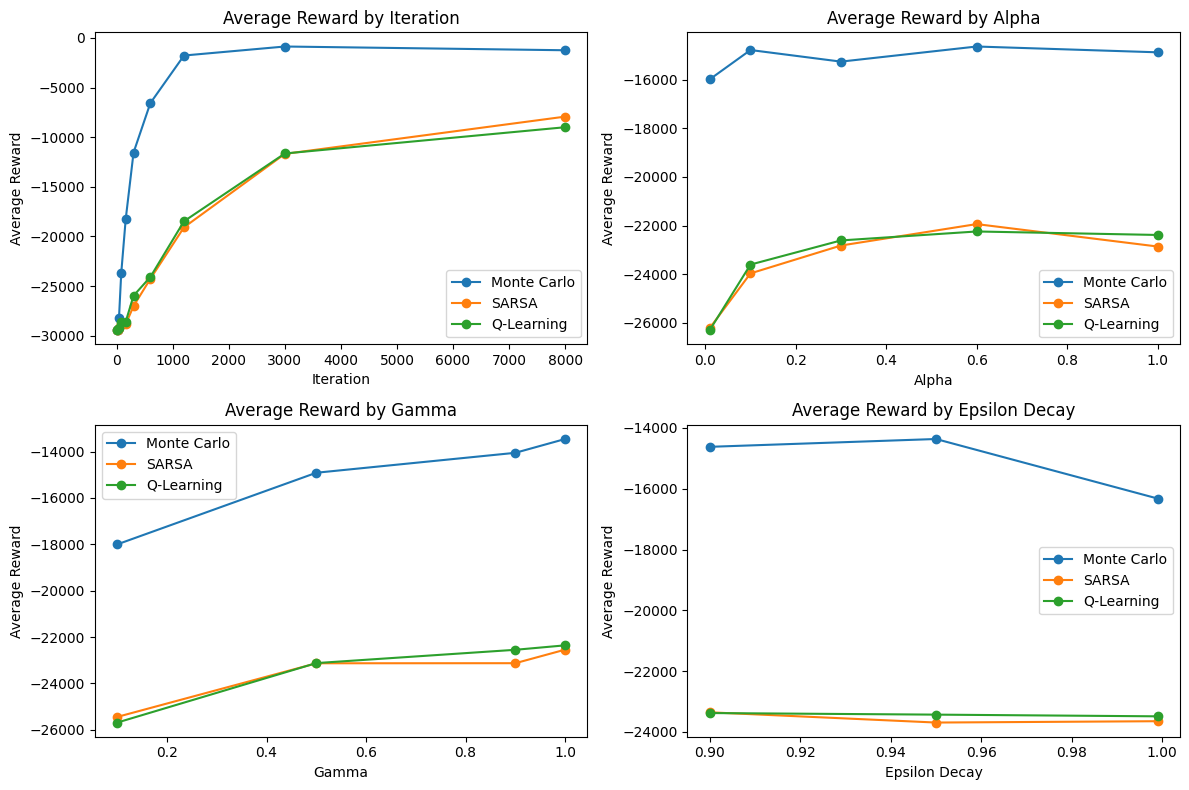

In [77]:
plot_grid_search(avg_rewardsMC, avg_rewardsSARSA,avg_rewardsQLEARN, labels=["Monte Carlo", "SARSA", "Q-Learning"])

In [41]:
max_time = 7
max_level = env.cap
parallel_coordinates_plot(MC_q_table, actions, max_time, max_level)

In [47]:
parallel_coordinates_plot(SARSA_q_table, actions, max_time, max_level)

In [52]:
parallel_coordinates_plot(QLEARN_q_table, actions, max_time, max_level)

In [57]:
parallel_coordinates_plot(DQN_q_table, actions, max_time, max_level)